In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import time
%matplotlib inline

# Best Subset Selection

Here we apply the best subset selection approach to the Hitters data. We
wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year. Let's take a quick look:

In [2]:
df = pd.read_csv('Hitters.csv')
df.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [3]:
df.columns

Index(['Player', 'AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years',
       'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')

In [4]:
df['Salary'].isnull().sum()

59

In [5]:
df.shape

(322, 21)

In [6]:
# drop any rows that contain missing values AND player names
df = df.dropna().drop('Player', axis=1)
df.shape

(263, 20)

In [7]:
df['Salary'].isnull().sum()

0

In [10]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

y = df.Salary

# drop column with independent variable (salary), and columns for dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# define feature set X

X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

We can perform best subset selection by identifying the best model that contains a given number of predictors, where **best** is quantified using RSS. We'll define a helper function to outputs the best set of variables for
each model size:

In [17]:
def processSubset(feature_set):
    # fit model on feature_set and calculate RSS
    model = sm.OLS(y, X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [18]:
def getBest(k):
   
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # put into dataframe
    models = pd.DataFrame(results)
    
    # choose model with lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a ${\tt DataFrame}$ containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

In [19]:
models = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()

for i in range(1,8):
    models.loc[i] = getBest(i)
    
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.09369206428527832 seconds.
Processed  171 models on 2 predictors in 0.31377315521240234 seconds.
Processed  969 models on 3 predictors in 2.264345169067383 seconds.
Processed  3876 models on 4 predictors in 7.309520959854126 seconds.
Processed  11628 models on 5 predictors in 20.676233053207397 seconds.
Processed  27132 models on 6 predictors in 47.71530795097351 seconds.
Processed  50388 models on 7 predictors in 102.11486792564392 seconds.
Total elapsed time: 180.54868698120117 seconds.


In [20]:
models

,RSS,model
1,4.321393e+07,<statsmodels.regression.linear_model.Regressio...
2,3.073305e+07,<statsmodels.regression.linear_model.Regressio...
3,2.941071e+07,<statsmodels.regression.linear_model.Regressio...
4,2.797678e+07,<statsmodels.regression.linear_model.Regressio...
5,2.718780e+07,<statsmodels.regression.linear_model.Regressio...
6,2.639772e+07,<statsmodels.regression.linear_model.Regressio...
7,2.606413e+07,<statsmodels.regression.linear_model.Regressio...


In [22]:
models.loc[2, "model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     416.7
Date:                Tue, 21 Mar 2017   Prob (F-statistic):           5.80e-82
Time:                        18:31:37   Log-Likelihood:                -1907.6
No. Observations:                 263   AIC:                             3819.
Df Residuals:                     261   BIC:                             3826.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.000         2.441     3.467
CRBI           0.6788      0.066     10.295      0.000         0.549     0.809
==============================================================================
Omnibus:                      117.551   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              654.612
Skew:                           1.729   Prob(JB):                    7.12e-143
Kurtosis:                       9.912   Cond. No.                         5.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
models.loc[7, "model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     144.2
Date:                Tue, 21 Mar 2017   Prob (F-statistic):           4.76e-85
Time:                        18:33:54   Log-Likelihood:                -1885.9
No. Observations:                 263   AIC:                             3786.
Df Residuals:                     256   BIC:                             3811.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Hits           1.6800      0.490      3.426      0.001         0.714     2.646
Walks          3.4000      1.196      2.843      0.005         1.045     5.755
CAtBat        -0.3288      0.090     -3.665      0.000        -0.506    -0.152
CHits          1.3470      0.312      4.316      0.000         0.732     1.962
CHmRun         1.3494      0.415      3.248      0.001         0.531     2.167
PutOuts        0.2482      0.074      3.336      0.001         0.102     0.395
Division_W  -111.9438     36.786     -3.043      0.003      -184.386   -39.502
==============================================================================
Omnibus:                      108.568   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              808.968
Skew:                           1.457   Prob(JB):                    2.16e-176
Kurtosis:                      11.082   Cond. No.                     6.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
dtype: float64

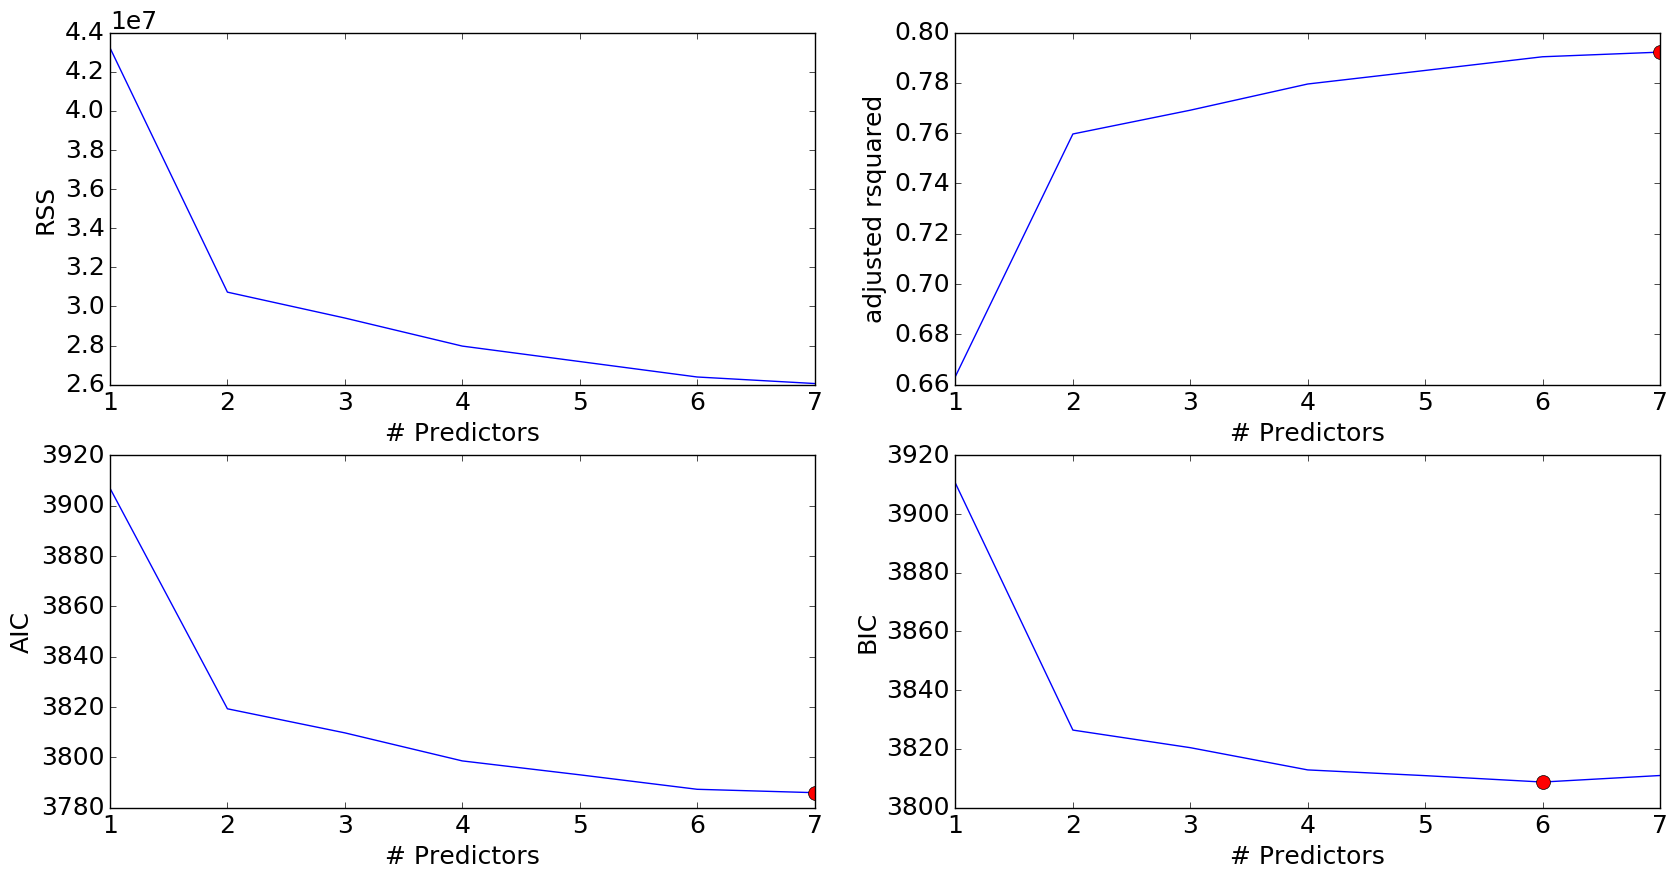

In [25]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Recall that in the second step of our selection process, we narrowed the field down to just one model on any  k<=pk<=p  predictors. We see that according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted  R2R2  something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

# Forward and Backward Stepwise Selection
We can also use a similar approach to perform forward stepwise
or backward stepwise selection, using a slight modification of the functions we defined above:

In [26]:
def forward(predictors):
    
    # pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
        
    # wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # return the best model, along with some other useful info about the model
    return best_model

In [27]:
models2 = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models2.loc[i] = forward(predictors)
    predictors = models2.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 1 predictors in 0.10868287086486816 seconds.
Processed  18 models on 2 predictors in 0.03612399101257324 seconds.
Processed  17 models on 3 predictors in 0.03498196601867676 seconds.
Processed  16 models on 4 predictors in 0.032269954681396484 seconds.
Processed  15 models on 5 predictors in 0.03294992446899414 seconds.
Processed  14 models on 6 predictors in 0.024657011032104492 seconds.
Processed  13 models on 7 predictors in 0.02619004249572754 seconds.
Processed  12 models on 8 predictors in 0.03461790084838867 seconds.
Processed  11 models on 9 predictors in 0.026485919952392578 seconds.
Processed  10 models on 10 predictors in 0.02560114860534668 seconds.
Processed  9 models on 11 predictors in 0.023952960968017578 seconds.
Processed  8 models on 12 predictors in 0.01649785041809082 seconds.
Processed  7 models on 13 predictors in 0.014683008193969727 seconds.
Processed  6 models on 14 predictors in 0.016276121139526367 seconds.
Processed  5 models on 15 p

In [28]:
print(models.loc[1, "model"].summary())
print(models.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     519.2
Date:                Fri, 24 Mar 2017   Prob (F-statistic):           4.20e-64
Time:                        11:57:03   Log-Likelihood:                -1952.4
No. Observations:                 263   AIC:                             3907.
Df Residuals:                     262   BIC:                             3910.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Hits           4.8833      0.214     22.787      0.0

In [29]:
print(models.loc[6, "model"].summary())
print(models2.loc[6, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     166.3
Date:                Fri, 24 Mar 2017   Prob (F-statistic):           1.79e-85
Time:                        11:58:18   Log-Likelihood:                -1887.6
No. Observations:                 263   AIC:                             3787.
Df Residuals:                     257   BIC:                             3809.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
AtBat         -1.5488      0.477     -3.248      0.0

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.

# Backward Selection
Not much has to change to implement backward selection... just looping through the predictors in reverse!

In [30]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [31]:
models3 = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models3.loc[len(predictors)-1] = backward(predictors)
    predictors = models3.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  19 models on 18 predictors in 0.08515501022338867 seconds.
Processed  18 models on 17 predictors in 0.04188895225524902 seconds.
Processed  17 models on 16 predictors in 0.0406801700592041 seconds.
Processed  16 models on 15 predictors in 0.03409314155578613 seconds.
Processed  15 models on 14 predictors in 0.032343149185180664 seconds.
Processed  14 models on 13 predictors in 0.03027796745300293 seconds.
Processed  13 models on 12 predictors in 0.02847003936767578 seconds.
Processed  12 models on 11 predictors in 0.0362391471862793 seconds.
Processed  11 models on 10 predictors in 0.022137880325317383 seconds.
Processed  10 models on 9 predictors in 0.018640995025634766 seconds.
Processed  9 models on 8 predictors in 0.017416000366210938 seconds.
Processed  8 models on 7 predictors in 0.01503300666809082 seconds.
Processed  7 models on 6 predictors in 0.013048887252807617 seconds.
Processed  6 models on 5 predictors in 0.01129603385925293 seconds.
Processed  5 models on 4 p

For this data, the best one-variable through six-variable
models are each identical for best subset and forward selection.
However, the best seven-variable models identified by forward stepwise selection,
backward stepwise selection, and best subset selection are different:

In [32]:
print(models.loc[7, "model"].params)

Hits            1.680029
Walks           3.399961
CAtBat         -0.328835
CHits           1.347017
CHmRun          1.349373
PutOuts         0.248166
Division_W   -111.943760
dtype: float64


In [33]:
print(models2.loc[7, "model"].params)

Hits            7.277149
CRBI            0.652415
Division_W   -110.656338
PutOuts         0.259787
AtBat          -1.644651
Walks           3.684324
League_N       49.978410
dtype: float64


In [34]:
print(models3.loc[7, "model"].params)

AtBat         -1.601655
Hits           6.148449
Walks          5.866033
CRuns          1.097453
CWalks        -0.650614
PutOuts        0.310125
Division_W   -95.027171
dtype: float64


# Model selection using the Validation Set Approach

In the previous lab, we saw that it is possible to choose among a set of models of different
sizes using $C_p$, BIC, and adjusted $R^2$. We will now consider how to do this
using the validation set and cross-validation approaches.

As in the previous lab, we'll be working with the ${\tt Hitters}$ dataset from ${\tt ISLR}$. Since we're trying to predict ${\tt Salary}$ and we know from last time that some are missing, let's first drop all the rows with missing values and do a little cleanup:

In [35]:
df = pd.read_csv('Hitters.csv')

# Drop any rows the contain missing values, along with the player names
df = df.dropna().drop('Player', axis=1)

# Get dummy variables
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

# Extract independent variable
y = pd.DataFrame(df.Salary)

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In order for the validation set approach to yield accurate estimates of the test
error, we must use *only the training observations* to perform all aspects of
model-fitting — including variable selection. Therefore, the determination of
which model of a given size is best must be made using *only the training
observations*. This point is subtle but important. If the full data set is used
to perform the best subset selection step, the validation set errors and
cross-validation errors that we obtain will not be accurate estimates of the
test error.

In order to use the validation set approach, we begin by splitting the
observations into a training set and a test set. We do this by creating
a random vector, train, of elements equal to TRUE if the corresponding
observation is in the training set, and FALSE otherwise. The vector test has
a TRUE if the observation is in the test set, and a FALSE otherwise. Note the
${\tt np.invert()}$ in the command to create test causes TRUEs to be switched to FALSEs and
vice versa. We also set a random seed so that the user will obtain the same
training set/test set split.

In [36]:
np.random.seed(seed=12)
train = np.random.choice([True, False], size = len(y), replace = True)
test = np.invert(train)

We'll define our helper function to outputs the best set of variables for each model size like we did in Lab 8. Not that we'll need to modify this to take in both test and training sets, because we want the returned error to be the **test** error:

In [38]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {"model":regr, "RSS":RSS}

And another function to perform forward selection:

In [39]:
def forward(predictors, X_train, y_train, X_test, y_test):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    # Return the best model, along with some other useful information about the model
    return best_model

Now, we'll call our ${\tt forward()}$ to the training set in order to perform forward selection for all nodel sizes:

In [40]:
models_train = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,len(X.columns)+1):    
    models_train.loc[i] = forward(predictors, X[train], y[train]["Salary"], X[test], y[test]["Salary"])
    predictors = models_train.loc[i]["model"].model.exog_names

Now let's plot the errors, and find the model that minimizes it:

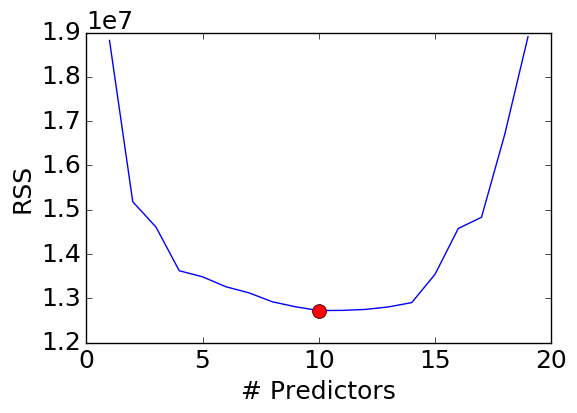

In [42]:
plt.plot(models_train["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_train["RSS"].argmin(), models_train["RSS"].min(), "or")

Viola! We find that the best model (according to the validation set approach) is the one that contains 10 predictors.

Now that we know what we're looking for, let's perform forward selection on the full dataset and select the best 10-predictor model. It is important that we make use of the *full
data set* in order to obtain more accurate coefficient estimates. Note that
we perform best subset selection on the full data set and select the best 10-predictor
model, rather than simply using the predictors that we obtained
from the training set, because the best 10-predictor model on the full data
set may differ from the corresponding model on the training set.

In [43]:
models_full = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,20):    
    models_full.loc[i] = forward(predictors, X, y["Salary"], X, y["Salary"])
    predictors = models_full.loc[i]["model"].model.exog_names

In fact, we see that the best ten-variable model on the full data set has a
**different set of predictors** than the best ten-variable model on the training
set:

In [44]:
print(models_train.loc[10, "model"].model.exog_names)
print(models_full.loc[10, "model"].model.exog_names)

['Walks', 'CRBI', 'Hits', 'Division_W', 'CWalks', 'CRuns', 'AtBat', 'League_N', 'CHits', 'Runs']
['Hits', 'CRBI', 'Division_W', 'PutOuts', 'AtBat', 'Walks', 'League_N', 'CWalks', 'CRuns', 'CAtBat']


# Model selection using Cross-Validation

Now let's try to choose among the models of different sizes using cross-validation.
This approach is somewhat involved, as we must perform forward selection within each of the $k$ training sets. Despite this, we see that
with its clever subsetting syntax, ${\tt python}$ makes this job quite easy. First, we
create a vector that assigns each observation to one of $k = 10$ folds, and
we create a DataFrame in which we will store the results:

In [52]:
folds

array([5, 8, 9, 5, 0, 0, 1, 7, 6, 9, 2, 4, 5, 2, 4, 2, 4, 7, 7, 9, 1, 7, 0,
       6, 9, 9, 7, 6, 9, 1, 0, 1, 8, 8, 3, 9, 8, 7, 3, 6, 5, 1, 9, 3, 4, 8,
       1, 4, 0, 3, 9, 2, 0, 4, 9, 2, 7, 7, 9, 8, 6, 9, 3, 7, 7, 4, 5, 9, 3,
       6, 8, 0, 2, 7, 7, 9, 7, 3, 0, 8, 7, 7, 1, 1, 3, 0, 8, 6, 4, 5, 6, 2,
       5, 7, 8, 4, 4, 7, 7, 4, 9, 0, 2, 0, 7, 1, 7, 9, 8, 4, 0, 1, 9, 8, 2,
       3, 1, 2, 7, 2, 6, 0, 9, 2, 6, 6, 2, 7, 7, 0, 6, 5, 1, 4, 6, 0, 6, 5,
       1, 2, 1, 5, 4, 0, 7, 8, 9, 5, 7, 0, 9, 3, 9, 1, 4, 4, 6, 8, 8, 9, 2,
       7, 5, 5, 4, 5, 8, 5, 8, 1, 1, 8, 7, 0, 3, 4, 2, 0, 3, 5, 1, 2, 4, 3,
       0, 6, 0, 7, 2, 8, 3, 0, 8, 4, 2, 9, 0, 3, 8, 1, 4, 3, 3, 6, 7, 3, 5,
       3, 2, 4, 4, 0, 3, 3, 8, 3, 5, 6, 7, 5, 1, 7, 0, 2, 8, 2, 1, 4, 0, 4,
       1, 7, 3, 1, 6, 6, 9, 6, 9, 6, 0, 0, 2, 9, 6, 0, 6, 7, 0, 3, 9, 0, 3,
       4, 7, 5, 3, 8, 8, 0, 6, 7, 9])

In [45]:
k=10        # number of folds
np.random.seed(seed=1)
folds = np.random.choice(k, size = len(y), replace = True)

# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,20))
cv_errors = cv_errors.fillna(0)
cv_errors

,1,2,3,4,5,6,7,8,9,10
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0


Now let's write a for loop that performs cross-validation. In the $j^{th}$ fold, the
elements of folds that equal $j$ are in the test set, and the remainder are in
the training set. We make our predictions for each model size, compute the test errors on the appropriate subset,
and store them in the appropriate slot in the matrix ${\tt cv.errors}$.

In [47]:
models_cv = pd.DataFrame(columns=["RSS", "model"])
    
# Outer loop iterates over all folds
for j in range(1,k+1):

    # Reset predictors
    predictors = []
    
    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)+1):    
    
        # The perform forward selection on the full dataset minus the jth fold, test on jth fold
        models_cv.loc[i] = forward(predictors, X[folds != (j-1)], y[folds != (j-1)]["Salary"], X[folds == (j-1)], y[folds == (j-1)]["Salary"])
        
        # Save the cross-validated error for this fold
        cv_errors[j][i] = models_cv.loc[i]["RSS"]

        # Extract the predictors
        predictors = models_cv.loc[i]["model"].model.exog_names

In [48]:
cv_errors

,1,2,3,4,5,6,7,8,9,10
1,3107900,3212304,4840103,2475453,3750302,1551976,1827366,9115194,1370720,2204862
2,2354036,2247881,3414444,1642455,3160950,1250564,1567469,8520751,1081052,1856304
3,2148733,2012864,3009435,1566581,2775618,907304,1260460,8456576,969784,1674333
4,1946031,1870511,2630784,1521525,2618750,805135,1143882,8331746,857553,1618265
5,1850398,1605148,2537690,1502728,2608466,776171,1124174,8221957,793919,1574253
6,1778324,1574266,2498621,1482575,2632055,776163,1115741,8196969,781235,1534220
7,1761111,1524413,2452303,1480345,2661104,779716,1104388,8171959,776457,1503831
8,1733230,1529625,2418943,1477510,2660654,803859,1100753,7449396,774589,1536790
9,1773705,1607919,2381843,1504519,2677002,821629,1096925,7136283,774616,1542746
10,1865909,1682293,2378624,1528102,2597881,854997,1136162,7059485,775993,1597314


This has filled up the ${\tt cv\_errors}$ DataFrame such that the $(i,j)^{th}$ element corresponds
to the test MSE for the $i^{th}$ cross-validation fold for the best $j$-variable
model.  We can then use the ${\tt apply()}$ function to take the ${\tt mean}$ over the columns of this
matrix. This will give us a vector for which the $j^{th}$ element is the cross-validation
error for the $j$-variable model.

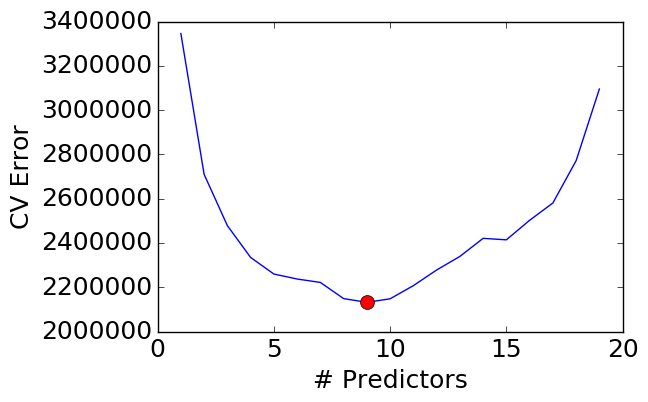

In [49]:
cv_mean = cv_errors.apply(np.mean, axis=1)

plt.plot(cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin(), cv_mean.min(), "or")

We see that cross-validation selects a 9-predictor model. Now let's go back to our results on the full data set in order to obtain the 9-predictor model.

In [50]:
print(models_full.loc[9, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     115.7
Date:                Fri, 24 Mar 2017   Prob (F-statistic):           1.35e-84
Time:                        12:36:43   Log-Likelihood:                -1881.8
No. Observations:                 263   AIC:                             3782.
Df Residuals:                     254   BIC:                             3814.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Hits           6.4382      1.622      3.970      0.0

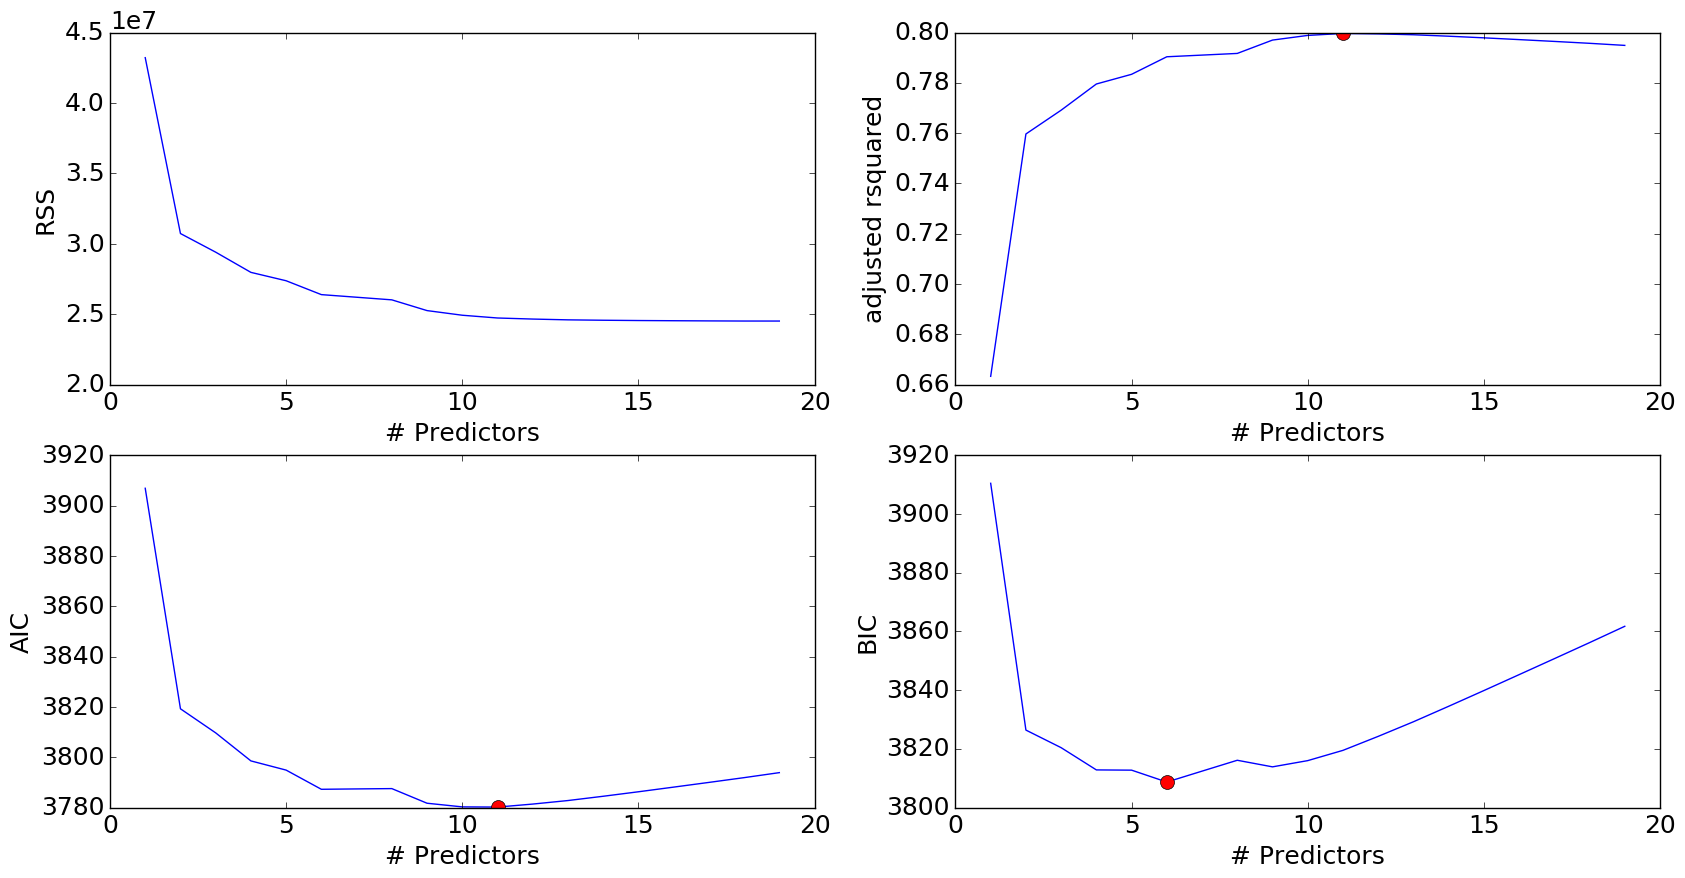

In [51]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_full["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_full.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_full.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_full.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

# Ridge Regression and the Lasso

In [53]:
from sklearn.preprocessing import scale 
from sklearn import cross_validation
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

We will use the ${\tt sklearn}$ package in order to perform ridge regression and
the lasso. The main functions in this package that we care about are ${\tt Ridge()}$, which can be used
to fit ridge regression models, and ${\tt Lasso()}$ which will fit lasso models. They also have cross-validated counterparts: ${\tt RidgeCV()}$ and ${\tt LassoCV()}$. We'll use these a bit later.

Before proceeding, let's first ensure that the missing values have
been removed from the data, as described in the previous lab.

In [54]:
df = pd.read_csv('Hitters.csv').dropna().drop('Player', axis=1)
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


We will now perform ridge regression and the lasso in order to predict ${\tt Salary}$ on
the ${\tt Hitters}$ data. Let's set up our data:

In [55]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null float64
Division_W     263 non-null float64
NewLeague_N    263 non-null float64
dtypes: float64(19)
memory usage: 41.1 KB


# Ridge Regression
The ${\tt Ridge()}$ function has an alpha argument ($\lambda$, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially
covering the full range of scenarios from the null model containing
only the intercept, to the least squares fit:

In [56]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([  5.00000000e+09,   3.78231664e+09,   2.86118383e+09,
         2.16438064e+09,   1.63727458e+09,   1.23853818e+09,
         9.36908711e+08,   7.08737081e+08,   5.36133611e+08,
         4.05565415e+08,   3.06795364e+08,   2.32079442e+08,
         1.75559587e+08,   1.32804389e+08,   1.00461650e+08,
         7.59955541e+07,   5.74878498e+07,   4.34874501e+07,
         3.28966612e+07,   2.48851178e+07,   1.88246790e+07,
         1.42401793e+07,   1.07721735e+07,   8.14875417e+06,
         6.16423370e+06,   4.66301673e+06,   3.52740116e+06,
         2.66834962e+06,   2.01850863e+06,   1.52692775e+06,
         1.15506485e+06,   8.73764200e+05,   6.60970574e+05,
         5.00000000e+05,   3.78231664e+05,   2.86118383e+05,
         2.16438064e+05,   1.63727458e+05,   1.23853818e+05,
         9.36908711e+04,   7.08737081e+04,   5.36133611e+04,
         4.05565415e+04,   3.06795364e+04,   2.32079442e+04,
         1.75559587e+04,   1.32804389e+04,   1.00461650e+04,
         7.59955541e+03,

Associated with each alpha value is a vector of ridge regression coefficients, which we'll
store in a matrix ${\tt coefs}$. In this case, it is a $19 \times 100$
matrix, with 19 rows (one for each predictor) and 100
columns (one for each value of alpha). Remember that we'll want to standardize the
variables so that they are on the same scale. To do this, we can use the
${\tt normalize=True}$ parameter:

In [57]:
ridge = Ridge(normalize=True)
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 19)

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,
when a large value of alpha is used, as compared to when a small value of alpha is
used. Let's plot and find out:

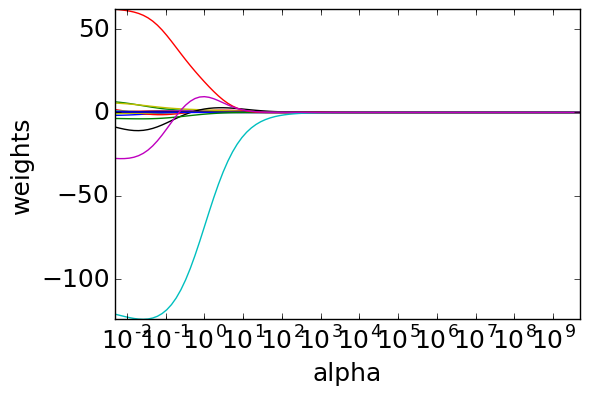

In [58]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso:

In [59]:
# Use the cross-validation package to split data into training and test sets
X_train, X_test , y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=1)

Next we fit a ridge regression model on the training set, and evaluate
its MSE on the test set, using $\lambda = 4$:

In [60]:
ridge2 = Ridge(alpha=4, normalize=True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))        # Calculate the test MSE

AtBat           0.098658
Hits            0.446094
HmRun           1.412107
Runs            0.660773
RBI             0.843403
Walks           1.008473
Years           2.779882
CAtBat          0.008244
CHits           0.034149
CHmRun          0.268634
CRuns           0.070407
CRBI            0.070060
CWalks          0.082795
PutOuts         0.104747
Assists        -0.003739
Errors          0.268363
League_N        4.241051
Division_W    -30.768885
NewLeague_N     4.123474
dtype: float64
106216.52238


The test MSE when alpha = 4 is 106216. Now let's see what happens if we use a huge value of alpha, say $10^{10}$:

In [61]:
ridge3 = Ridge(alpha=10**10, normalize=True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))        # Calculate the test MSE

AtBat          1.317464e-10
Hits           4.647486e-10
HmRun          2.079865e-09
Runs           7.726175e-10
RBI            9.390640e-10
Walks          9.769219e-10
Years          3.961442e-09
CAtBat         1.060533e-11
CHits          3.993605e-11
CHmRun         2.959428e-10
CRuns          8.245247e-11
CRBI           7.795451e-11
CWalks         9.894387e-11
PutOuts        7.268991e-11
Assists       -2.615885e-12
Errors         2.084514e-10
League_N      -2.501281e-09
Division_W    -1.549951e-08
NewLeague_N   -2.023196e-09
dtype: float64
172862.235804


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test
MSE than fitting a model with just an intercept. We now check whether
there is any benefit to performing ridge regression with alpha = 4 instead of
just performing least squares regression. Recall that least squares is simply
ridge regression with alpha = 0.

In [63]:
ridge2 = Ridge(alpha=0, normalize=True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))         # Calculate the test MSE

AtBat           -1.821115
Hits             4.259156
HmRun           -4.773401
Runs            -0.038760
RBI              3.984578
Walks            3.470126
Years            9.498236
CAtBat          -0.605129
CHits            2.174979
CHmRun           2.979306
CRuns            0.266356
CRBI            -0.598456
CWalks           0.171383
PutOuts          0.421063
Assists          0.464379
Errors          -6.024576
League_N       133.743163
Division_W    -113.743875
NewLeague_N    -81.927763
dtype: float64
116690.468567


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha $ = 4$, it would be better to
use cross-validation to choose the tuning parameter alpha. We can do this using
the cross-validated ridge regression function, ${\tt RidgeCV()}$. By default, the function
performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the
argument ${\tt cv}$.

In [64]:
ridgecv = RidgeCV(alphas=alphas, scoring='mean_squared_error', normalize=True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.57487849769886779

Therefore, we see that the value of alpha that results in the smallest cross-validation
error is 0.57. What is the test MSE associated with this value of
alpha?

In [65]:
ridge4 = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

99825.648962927298

This represents a further improvement over the test MSE that we got using
alpha $ = 4$. Finally, we refit our ridge regression model on the full data set,
using the value of alpha chosen by cross-validation, and examine the coefficient
estimates.

In [66]:
ridge4.fit(X, y)
pd.Series(ridge4.coef_, index=X.columns)

AtBat           0.055838
Hits            0.934879
HmRun           0.369048
Runs            1.092480
RBI             0.878259
Walks           1.717770
Years           0.783515
CAtBat          0.011318
CHits           0.061101
CHmRun          0.428333
CRuns           0.121418
CRBI            0.129351
CWalks          0.041990
PutOuts         0.179957
Assists         0.035737
Errors         -1.597699
League_N       24.774519
Division_W    -85.948661
NewLeague_N     8.336918
dtype: float64

As expected, none of the coefficients are exactly zero - ridge regression does not
perform variable selection!

# The Lasso
We saw that ridge regression with a wise choice of alpha can outperform least
squares as well as the null model on the Hitters data set. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we'll
use the ${\tt Lasso()}$ function; however, this time we'll need to include the argument ${\tt max_iter=10000}$.
Other than that change, we proceed just as we did in fitting a ridge model:

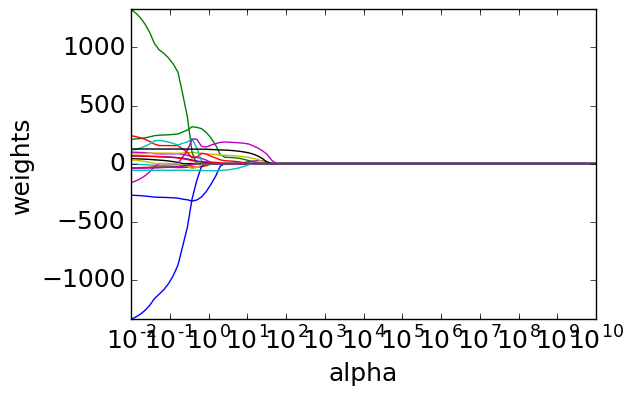

In [67]:
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [68]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

104960.65853895503

This is substantially lower than the test set MSE of the null model and of
least squares, and only a little worse than the test MSE of ridge regression with alpha
chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 13 of
the 19 coefficient estimates are exactly zero:

In [69]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat           0.000000
Hits            1.082446
HmRun           0.000000
Runs            0.000000
RBI             0.000000
Walks           2.906388
Years           0.000000
CAtBat          0.000000
CHits           0.000000
CHmRun          0.219367
CRuns           0.000000
CRBI            0.513975
CWalks          0.000000
PutOuts         0.368401
Assists        -0.000000
Errors         -0.000000
League_N        0.000000
Division_W    -89.064338
NewLeague_N     0.000000
dtype: float64

# Principal Components Regression

Principal components regression (PCR) can be performed using the ${\tt PCA()}$
function, which is part of the ${\tt sklearn}$ library. In this lab, we'll apply PCR to the ${\tt Hitters}$
data, in order to predict ${\tt Salary}$. As in previous labs, we'll start by ensuring that the missing values have
been removed from the data:

In [70]:
from sklearn.preprocessing import scale 
from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error


df = pd.read_csv('Hitters.csv').dropna().drop('Player', axis=1)
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [71]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

Unfortunately ${\tt sklearn}$ does not have an implementation of PCA and regression combined like the ${\tt pls}$, package in R: https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf so we'll have to do it ourselves.

We'll start by performing Principal Components Analysis (PCA), remembering to scale the data:

In [72]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

Let's print out the first few variables of the first few principal components:

In [73]:
pd.DataFrame(pca.components_.T).loc[:4,:5]

,0,1,2,3,4,5
0,0.198290,0.383784,-0.088626,0.031967,-0.028117,0.070646
1,0.195861,0.377271,-0.074032,0.017982,0.004652,0.082240
2,0.204369,0.237136,0.216186,-0.235831,-0.077660,0.149646
3,0.198337,0.377721,0.017166,-0.049942,0.038536,0.136660
4,0.235174,0.314531,0.073085,-0.138985,-0.024299,0.111675


Now we'll perform 10-fold cross-validation to see how it influences the MSE:

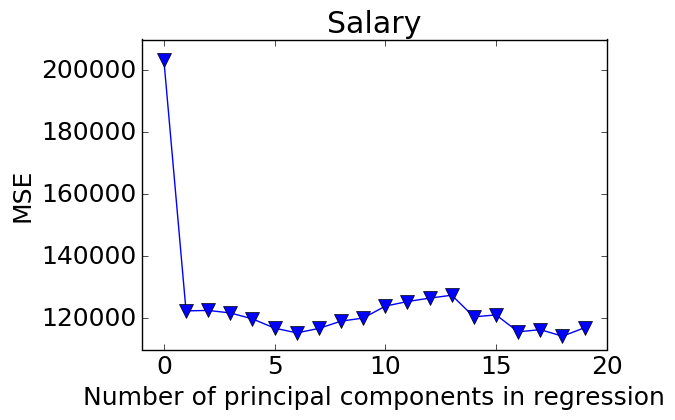

In [74]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_validation.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

We see that the smallest cross-validation error occurs when $M = 18$ components
are used. This is barely fewer than $M = 19$, which amounts to
simply performing least squares, because when all of the components are
used in PCR no dimension reduction occurs. However, from the plot we
also see that the cross-validation error is roughly the same when only one
component is included in the model. This suggests that a model that uses
just a small number of components might suffice.

We'll do a little math to get the amount of variance explained by adding each consecutive principal component:

In [75]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 38.31,  60.15,  70.84,  79.03,  84.29,  88.63,  92.26,  94.96,
        96.28,  97.25,  97.97,  98.64,  99.14,  99.46,  99.73,  99.88,
        99.95,  99.98,  99.99])

We'll dig deeper into this concept in Chapter 10, but for now we can think of this as the amount of information about the predictors or the response that is captured using $M$ principal components. For example,
setting $M = 1$ only captures 38.31% of all the variance, or information, in
the predictors. In contrast, using $M = 6$ increases the value to 88.63%. If
we were to use all $M = p = 19$ components, this would increase to 100%.

Now let's perform PCA on the training data and evaluate its test set
performance:

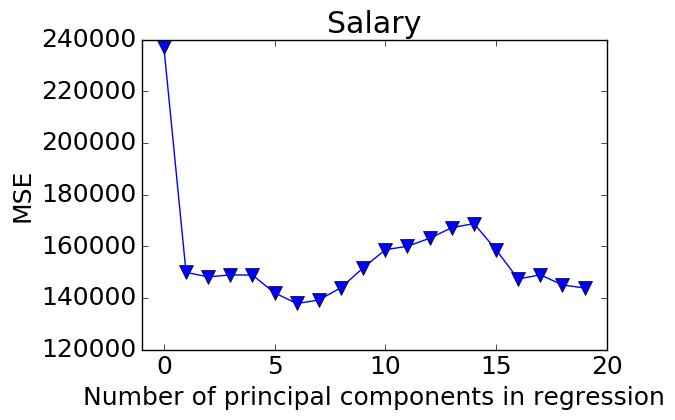

In [76]:
pca2 = PCA()

# Split into training and test sets
X_train, X_test , y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=1)

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_validation.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

We find that the lowest cross-validation error occurs when $M = 6$
components are used. Now we'll see how it performs on the test data and compute the test MSE as follows:

In [77]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

111994.42273636986

This test set MSE is competitive with the results obtained using ridge regression
and the lasso. However, as a result of the way PCR is implemented,
the final model is more difficult to interpret because it does not perform
any kind of variable selection or even directly produce coefficient estimates.

# Partial Least Squares

Scikit-learn ${\tt PLSRegression}$ gives same results as the ${\tt pls}$ package in R when using ${\tt method='oscorespls'}$. However, the standard method used is ${\tt 'kernelpls'}$, which we'll use here. Feel free to try out both.

(-1, 20.0)

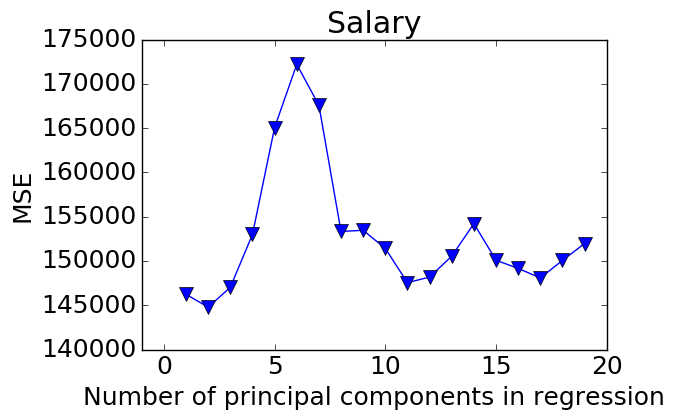

In [78]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = cross_validation.KFold(n, n_folds=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_validation.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)

The lowest cross-validation error occurs when only $M = 2$ partial least
squares directions are used. We now evaluate the corresponding test set
MSE:

In [79]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

104711.20627773693

The test MSE is again comparable to the test MSE
obtained using ridge regression, the lasso, and PCR.

In [80]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

%matplotlib inline

# Polynomial Regression

In this lab, we'll explore how to generate the ${\tt Wage}$ dataset models we saw in class.

In [81]:
df = pd.read_csv('Wage.csv')
df.head(3)

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


We first fit the polynomial regression model using the following commands:

In [83]:
X1 = PolynomialFeatures(1).fit_transform(df.age.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.reshape(-1,1))

This syntax fits a linear model, using the ${\tt PolynomialFeatures()}$ function, in order to predict
wage using up to a fourth-degree polynomial in ${\tt age}$. The ${\tt PolynomialFeatures()}$ command
allows us to avoid having to write out a long formula with powers
of ${\tt age}$. We can then fit our linear model:

In [87]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
const,-184.1542,60.040,-3.067,0.002,-301.879 -66.430
x1,21.2455,5.887,3.609,0.000,9.703 32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968 -0.160
x3,0.0068,0.003,2.221,0.026,0.001 0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05 1.45e-07


Next we consider the task of predicting whether an individual earns more
than \$250,000 per year. We proceed much as before, except that first we
create the appropriate response vector, and then we fit a logistic model using the ${\tt GLM()}$ function from ${\tt statsmodels}$:

In [88]:
# Create response matrix
y = (df.wage > 250).map({False:0, True:1}).as_matrix()

# Fit logistic model
clf = sm.GLM(y, X4, family=sm.families.Binomial(sm.families.links.logit))
res = clf.fit()

We now create a grid of values for ${\tt age}$ at which we want predictions, and
then call the generic ${\tt predict()}$ function for each model:

In [90]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Generate test data
X_test = PolynomialFeatures(4).fit_transform(age_grid)

# Predict the value of the generated ages
pred1 = fit2.predict(X_test) # salary
pred2 = res.predict(X_test)  # Pr(wage>250)

Finally, we plot the data and add the fit from the degree-4 polynomial.

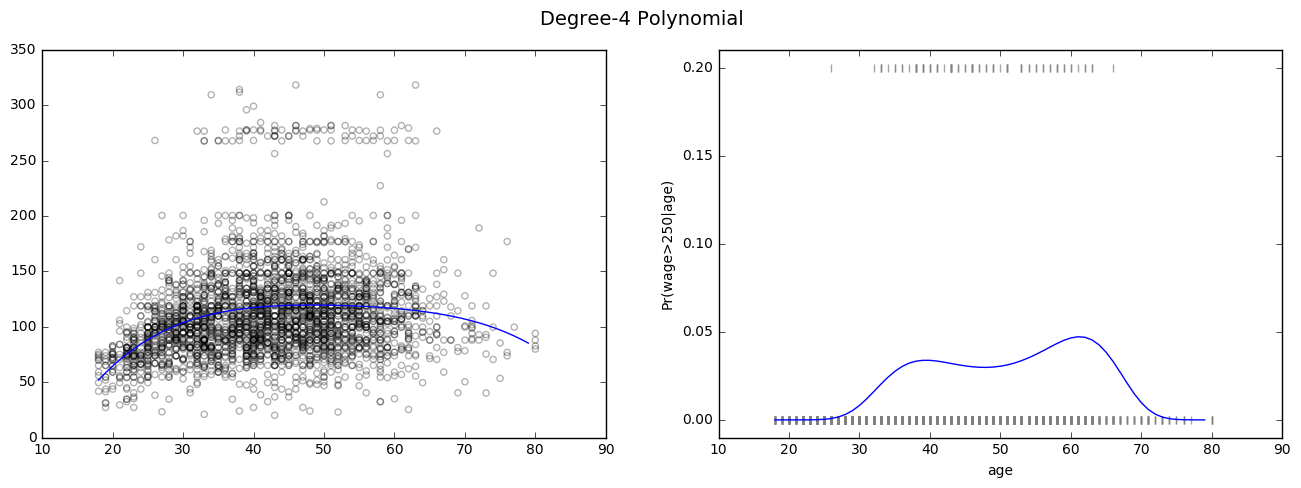

In [91]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred1, color = 'b')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred2, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

# Deciding on a degree

In performing a polynomial regression we must decide on the degree of
the polynomial to use. One way to do this is by using hypothesis tests. We
now fit models ranging from linear to a degree-5 polynomial and seek to
determine the simplest model which is sufficient to explain the relationship
between ${\tt wage}$ and ${\tt age}$.

We can do this using the ${\tt anova\_lm()}$ function, which performs an
analysis of variance (ANOVA, using an F-test) in order to test the null
hypothesis that a model $M_1$ is sufficient to explain the data against the 
alternative hypothesis that a more complex model $M_2$ is required. In order
to use the ${\tt anova\_lm()}$ function, $M_1$ and $M_2$ must be **nested models**: the
predictors in $M_1$ must be a subset of the predictors in $M_2$. In this case,
we fit five different models and sequentially compare the simpler model to
the more complex model:

In [92]:
fit_1 = fit = sm.GLS(df.wage, X1).fit()
fit_2 = fit = sm.GLS(df.wage, X2).fit()
fit_3 = fit = sm.GLS(df.wage, X3).fit()
fit_4 = fit = sm.GLS(df.wage, X4).fit()
fit_5 = fit = sm.GLS(df.wage, X5).fit()

print(sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


The $p$-value comparing the linear Model 1 to the quadratic Model 2 is
essentially zero $(<10^{-32})$, indicating that a linear fit is not sufficient. Similarly
the $p$-value comparing the quadratic Model 2 to the cubic Model 3
is very low (0.0017), so the quadratic fit is also insufficient. The $p$-value
comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is approximately
0.05 while the degree-5 polynomial Model 5 seems unnecessary
because its $p$-value is 0.37. Hence, either a cubic or a quartic polynomial
appear to provide a reasonable fit to the data, but lower- or higher-order
models are not justified.

As an alternative to using hypothesis tests and ANOVA, we could choose
the polynomial degree using cross-validation as we have in previous labs.